# Python library installation 
These are libraries that need to be installed in python to run the code in this notebook.

In [480]:
! pip install pubchempy
! pip install rdkit
! pip install pandas
! pip install scikit-learn
! pip install imbalanced-learn



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


# Imports

In [387]:
# basic data process libraries
import pandas as pd
import numpy as np

# machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score,
                             f1_score, confusion_matrix, classification_report,
                             log_loss, matthews_corrcoef, roc_curve, precision_recall_curve)

# public chemistry libraries
import pubchempy as pcp
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

# other tools for drawing and store/restore python objects
import matplotlib.pyplot as plt
import pickle


# ATC database 

The recent ATC database can be downloaded from https://bioportal.bioontology.org/ontologies/ATC. ATC classes are structured in 5 levels and we use level-5 names to find compounds.  


In [379]:
# The atc.csv file is previously downloaded from https://bioportal.bioontology.org/ontologies/ATC
atc_filename = 'atc.csv'
atc = pd.read_csv(atc_filename)
atc = atc[atc['ATC LEVEL'] == 5] # keep only level 5
atc = atc[atc['Obsolete'] != 'False'] # remove obsolete data
print("total number of Level-5s:", len(atc)) 


total number of Level-5s: 5372


To collect the compounds that are used for acne treatments, we could use all names under level-3 D10B or level-2 D10. D10 class covers all acne medicines, D10A covers only "topoical use", and D10B covers only "system use". In our work, we end up using D10A only because "system use" and "topical use" are very different in nature and our model might not learn well if we mixed them together.  

In [381]:
atc_positive_A = atc[atc['Class ID'].str.contains('/D10A', na=False)]
atc_positive_B = atc[atc['Class ID'].str.contains('/D10B', na=False)]
atc_positive = atc[atc['Class ID'].str.contains('/D10', na=False)]
atc_positive = set(atc_positive_A["Preferred Label"])
print("number of medicines for positive dataset:", len(atc_positive))

number of medicines for positive dataset: 34


In ATC database, the same medicine can appear for multiple class if the medicine is used for the treatment for more than one medical conditions. We need only the unique names.

In [384]:
atc_all = set(atc["Preferred Label"])
print("number of unique medicine names:", len(atc_all))

atc_negative = atc_all - atc_positive
print("number of unique medicine names for negative dataset:", len(atc_negative))


number of unique medicine names: 4686
number of unique medicine names for negative dataset: 4652


# Functions for collecting compound infomation and features from PubChem and RDkit

In [391]:
DESCRIPTOR_NAMES = [desc_name[0] for desc_name in Descriptors._descList]


# Get compound information from pubchem website for one compound name. It calls pubchem website so we need to be nice. First, when trying to collect information 
# for a large number of compounds, we cut them into smaller batches so that we do not burden the pubchem website. Second, this information only need to be collected once, 
# so we save the infomation with pickle and reuse it later without calling pubchem again.
def getCompounds(names):
    data = {}
    for chemical_name in names:
        compounds = pcp.get_compounds(chemical_name, 'name')
        data[chemical_name] = compounds
    return data


# The following functions get features from PubChem and RDKit. Function getFeatures() wrap all of them together.

# List of features collected from PubChem. Note some of features are in string format so we need to convert them to numbers later.
def getFeaturesFromPubChem(compound):
    x_dict = compound.to_dict()
    count_keys = ['atom_stereo_count', 'bond_stereo_count', 'charge', 'complexity', 'covalent_unit_count', 'defined_atom_stereo_count', 'defined_bond_stereo_count', 
              'exact_mass', 'h_bond_acceptor_count', 'h_bond_donor_count', 
              'heavy_atom_count', 
              'isotope_atom_count', 
              'molecular_weight', 'monoisotopic_mass', 
              'rotatable_bond_count', 'tpsa', 'undefined_atom_stereo_count', 'undefined_bond_stereo_count', 
              'volume_3d', 'xlogp']
    subset_dict = {key: x_dict[key] for key in count_keys}
    #print(subset_dict["exact_mass"])

    return subset_dict

# Collecting features from the RDKit library.
def getRdkitMoleculeFromPubChemCompound(compound):
    return Chem.MolFromInchi(compound.inchi) 

def getFeaturesFromChem(molelcule, descriptor_names=DESCRIPTOR_NAMES):
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    descriptors = calculator.CalcDescriptors(molelcule)

    descriptor_dict = dict(zip(DESCRIPTOR_NAMES, descriptors))

    return descriptor_dict

def getFeaturesFromRdkit(compound, descriptor_names=DESCRIPTOR_NAMES):
    molecule = getRdkitMoleculeFromPubChemCompound(compound)
    
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    descriptors = calculator.CalcDescriptors(molecule)

    descriptor_dict = dict(zip(descriptor_names, descriptors))
    return descriptor_dict


# Combining features from both PubChem and RDKit
def getFeatures(compound):
    dict_1 = getFeaturesFromPubChem(compound);
    dict_2 = getFeaturesFromRdkit(compound, DESCRIPTOR_NAMES)
    return dict_1 | dict_2


# The following two functions are used to save/load compound and feature information to files so that we do not have to regenerate them every time we restart this notebook.

def save_object_to_disk(data, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)
        print("Python object has been saved to file.")

def load_object_from_disk(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        print("Python object has been loaded from file.")
        return data 

# Collecting compound infomation from PubChem 


Medicine names in the ATC database are cut into batches so that we can collect information from PubChem with 5-second breaks. This way we don't burden PubChem too much. The collected data are saved to file using pickle so that it can be reused even after the notebook is restarted. 

In [16]:
atc_cpmd_names_batches = [atc_cpmd_names[i:i + 30] for i in range(0, len(atc_cpmd_names), 30)]
atc_cpmd_names_batches

NameError: name 'atc_cpmd_names' is not defined

In [17]:
import time
atc_cpmds_batches = []
for index, batch in enumerate(atc_cpmd_names_batches):
    print(f"batch {index}")
    atc_cpmds = getCompounds(batch)
    atc_cpmds_batches.append(atc_cpmds)
    time.sleep(5)

NameError: name 'atc_cpmd_names_batches' is not defined

In [394]:
# remove the # to save  atc_cpmds_batches into atc_cpmds_batches.pkl
#save_object_to_disk(atc_cpmds_batches, 'atc_cpmds_batches.pkl')

## Join compound info with ATC info to differentiate positive dataset and negative dataset

When calling PubChem, we couldn't find every medicine in the PubChem database and sometimes one medicine name can be associated with multiple compounds. We already did some manual cleaning of the medicine name when checking with PubChem, but we can use more effort here in mapping medicine names to compounds.

In [395]:
atc_cpmds_batches = load_object_from_disk('atc_cpmds_batches.pkl')
all_atc_cpmds =  [item for sublist in atc_cpmds_batches for item in sublist.items()]
print("total number of compounds:", len(all_atc_cpmds))

Python object has been loaded from file.
total number of compounds: 6765


In [107]:
print("atc_positive: ", len(atc_positive))
all_atc_cpmds[0]
positive_data = [i for i in all_atc_cpmds if i[0] in atc_positive]
positive_data = list({k: v for k, v in positive_data if len(v) > 0}.items())
print("positive_data: ", len(positive_data))

positive_compounds = [v for k, v_list in positive_data for v in v_list]
print("positive_compounds: ", len(positive_compounds))

atc_positive:  34
positive_data:  27
positive_compounds:  27


In [105]:
atc_positive

{'adapalene',
 'adapalene, combinations',
 'aluminium chloride',
 'aluminium oxide',
 'azelaic acid',
 'benzoyl peroxide',
 'benzoyl peroxide, combinations',
 'bithionol',
 'chloramphenicol',
 'clascoterone',
 'clindamycin',
 'clindamycin, combinations',
 'dapsone',
 'dexamethasone',
 'erythromycin',
 'erythromycin, combinations',
 'fluorometholone',
 'isotretinoin',
 'isotretinoin, combinations',
 'meclocycline',
 'mesulfen',
 'methylprednisolone',
 'minocycline',
 'motretinide',
 'nadifloxacin',
 'resorcinol',
 'retinol',
 'sulfacetamide',
 'sulfur',
 'tioxolone',
 'tretinoin',
 'tretinoin, combinations',
 'trifarotene',
 'various other anti-acne preparation combinations for topical use in ATC'}

In [108]:
print("atc_negative: ", len(atc_negative))
negative_data = [i for i in all_atc_cpmds if i[0] in atc_negative]
negative_data = list({k: v for k, v in negative_data if len(v) > 0}.items())
print("negative_data: ", len(negative_data))

negative_compounds = [v for k, v_list in negative_data for v in v_list]
print("negative_compounds: ", len(negative_compounds))


atc_negative:  4652
negative_data:  3120
negative_compounds:  4343


## Extract features from PubChem and RDKit

In [109]:
negative_features = [getFeatures(compound) for compound in negative_compounds]
positive_features = [getFeatures(compound) for compound in positive_compounds]
print(len(negative_features), len(positive_features))

4343 27


In [403]:
# We have 4343 negative samples and 27 positive training samples. 
# show one example training sample
positive_features[0]

{'atom_stereo_count': 0,
 'bond_stereo_count': 0,
 'charge': 0,
 'complexity': 64.9,
 'covalent_unit_count': 1,
 'defined_atom_stereo_count': 0,
 'defined_bond_stereo_count': 0,
 'exact_mass': '110.036779430',
 'h_bond_acceptor_count': 2,
 'h_bond_donor_count': 2,
 'heavy_atom_count': 8,
 'isotope_atom_count': 0,
 'molecular_weight': '110.11',
 'monoisotopic_mass': '110.036779430',
 'rotatable_bond_count': 0,
 'tpsa': 40.5,
 'undefined_atom_stereo_count': 0,
 'undefined_bond_stereo_count': 0,
 'volume_3d': None,
 'xlogp': 0.8,
 'MaxAbsEStateIndex': 8.653055555555556,
 'MaxEStateIndex': 8.653055555555556,
 'MinAbsEStateIndex': 0.08796296296296324,
 'MinEStateIndex': 0.08796296296296324,
 'qed': 0.5245841402909771,
 'SPS': 9.0,
 'MolWt': 110.11199999999998,
 'HeavyAtomMolWt': 104.06399999999998,
 'ExactMolWt': 110.036779432,
 'NumValenceElectrons': 42,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.11876367378629811,
 'MinPartialCharge': -0.5078233297968214,
 'MaxAbsPartialCharge': 0.

In [410]:
# we collected 230 features in total from PubChem and RDKit
print("Number of features: ", len(positive_features[0].keys()))

Number of features:  230


# Training Functions

## Step 1: exploring training parameters with 5-fold cross valiation
As described in the paper, to overcome the challenge caused by the very imbalanced dataset and very small number of positive samples, we used all data for training with stritified 5-fold cross validation. We also use ADASYN algorithm to make the training set more balanced between negative and positive samples. The following function captured the above designs. 

In [459]:
def trainModel4(X, Y, feature_list, n_estimators = 48, random_state=42, stratify=y, n_splits=5, sampling_strategy = 0.20):
    """
    This function used all data for training with stritified 5-fold cross validation. It also uses ADASYN algorithm to 
    make the training set more balanced between negative and positive samples.  
    
    Parameters:
    X: Features
    Y: Labels
    feature_list: the names of features that will actually be used for model fitting
    n_estimators: number of trees in the resulting random forrest model
    random_state: random seed
    stratify: use stritified sampling
    n_splits: number of splits in multiple-fold cross validation.
    sampling_strategy: strategy used for ADASYN

    Returns:
    Average ROC_AUC score across all fold
    List of ROC_AUC scores across all fold
    
    """
    import pandas as pd
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    import numpy as np
    from imblearn.over_sampling import ADASYN
    from sklearn.metrics import classification_report
    from sklearn.model_selection import StratifiedKFold, cross_val_score


    # Create a DataFrame for features
    df_X = pd.DataFrame(X)[feature_list]


    # feature cleaning: some numbers are in string format, convert them to numbers
    string_columns = df_X.select_dtypes(include='object').columns.tolist()
    for i in string_columns:
        df_X[i] = pd.to_numeric(df_X[i])

    # feature cleaning: replace NAN and INF with special values. They are rare in the data but cause errors if not replaced.
    df_X.replace([np.nan], -1, inplace=True)
    df_X.replace([np.inf], np.finfo(np.float32).max, inplace=True)
    df_X.replace([-np.inf], np.finfo(np.float32).min, inplace=True)

    # feature cleaning: some numbers in RDKit is too large for float32
    df_X.loc[df_X['Ipc'] > 3.4028235e38, 'Ipc'] = np.finfo(np.float32).max  

    clf = RandomForestClassifier(
        class_weight='balanced',
        n_estimators=n_estimators, 
        random_state=4999,
        max_features='sqrt',  # each tree use sqrt(230) features
        bootstrap=True  
    )
    
    # Initialize StratifiedKFold with 5 splits
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    auc_scores = []

    for train_index, test_index in skf.split(X, Y):
        # Split the data into train and test sets for this fold
        X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]  # Use .iloc for pandas DataFrame
        y_train, y_test = [Y[i] for i in train_index], [Y[i] for i in test_index]  


        adasyn = ADASYN( 
            sampling_strategy = sampling_strategy,
            random_state=42)
        X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
        
        # fit the model with the training parts
        clf.fit(X_train_res, y_train_res)

        # predict on the test part
        y_pred_proba = clf.predict_proba(X_test)[:, 1]

        # Calculate AUC for this fold
        auc = roc_auc_score(y_test, y_pred_proba)
        auc_scores.append(auc)

    # Output the AUC scores
    print("AUC Scores for each fold:", auc_scores)
    print("Mean AUC Score:", np.mean(auc_scores))
    
    #return np.mean(auc_scores), auc_scores 



## Step 2: use all training data to train the final model using the selected parameters from Step 1
This step is almost the same as the Step 1 except that all data are used for training and there is splitting for train and test. The final evaluation metrics is also generated using the full dataset.

In [476]:
def trainModelFinal(X, Y, feature_list, n_estimators = 48, random_state=42, sampling_strategy = 0.15):
    """
    This function used all data for training the final model. It also uses ADASYN algorithm to 
    make the training set more balanced between negative and positive samples.  
    
    Parameters:
    X: Features
    Y: Labels
    feature_list: the names of features that will actually be used for model fitting
    n_estimators: number of trees in the resulting random forrest model
    random_state: random seed
    stratify: use stritified sampling
    sampling_strategy: strategy used for ADASYN

    Returns:
    Model
    Feature importance
    
    """
 
    import pandas as pd
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    import numpy as np
    from imblearn.over_sampling import ADASYN
    from sklearn.metrics import classification_report

    # Create a DataFrame for features
    df_X = pd.DataFrame(X)[feature_list]


    # feature cleaning: some numbers are in string format, convert them to numbers
    string_columns = df_X.select_dtypes(include='object').columns.tolist()
    for i in string_columns:
        df_X[i] = pd.to_numeric(df_X[i])

    # feature cleaning: replace NAN and INF with special values. They are rare in the data but cause errors if not replaced.
    df_X.replace([np.nan], -1, inplace=True)
    df_X.replace([np.inf], np.finfo(np.float32).max, inplace=True)
    df_X.replace([-np.inf], np.finfo(np.float32).min, inplace=True)

    # feature cleaning: some numbers in RDKit is too large for float32
    df_X.loc[df_X['Ipc'] > 3.4028235e38, 'Ipc'] = np.finfo(np.float32).max  


    # All data are used for training and all data are used for evaluation
    X_train, X_test, y_train, y_test = df_X, df_X, Y, Y
    
    print("number of training/test data before adasyn: ", len(X_train), len(X_test))
        
    # Apply ADASYN to increase the number of positive samples
    adasyn = ADASYN(
        #sampling_strategy='minority', # this bring minority to same number as the majority 
        sampling_strategy = sampling_strategy,
        random_state=42)
    X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

    print("number of training/test data after adasyn: ", len(X_train_res))
    
    # Training dataset is imbalanced. So we use class_weight='balanced'
    model = RandomForestClassifier(
        class_weight='balanced',
        n_estimators=n_estimators, 
        random_state=4999,
        max_features='sqrt',  # each tree use sqrt(230) features
        bootstrap=True  
    )
    model.fit(X_train_res, y_train_res)

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class


    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f'AUC: {auc:.2f}')

    # Metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # PR Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)

    # Print metrics
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)
    print(f'Log Loss: {logloss:.2f}')
    print(f'Matthews Correlation Coefficient: {mcc:.2f}')

    # Plot ROC Curve
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

    # Plot PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_curve, precision_curve, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    plt.tight_layout()
    plt.show()
    
    importances = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': df_X.columns,
        'Importance': importances
    })

    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Display the DataFrame
    pd.set_option('display.max_rows', None)  # Show all rows
    pd.set_option('display.max_columns', None)  # Show all columns
    print(feature_importance_df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

    return model, feature_importance_df

# Training Process

The training process is a iteration of Step 1 and Step 2. Step 1 uses 5-fold cross validation to find the best training parameters, while Step 2 uses the selected parameter to the train the final model for the iteration using the full dataset. 

The iterations is for trimming down the number of features. The training set has 230 features, which is too many considering we have only thoushands of training samples.
 

## Iteration I

The parameter feature_list is the list of feature names. There are originally 230 features. 

In [431]:
# Step 1
avg_auc_score, auc_scores = trainModel4(
    X, Y, 
    feature_list = positive_features[0].keys(),
    n_estimators = 300, 
    random_state=220, 
    n_splits=5, 
    sampling_strategy = 0.20)

AUC Scores for each fold: [0.7370540851553511, 0.7973532796317606, 0.8486766398158803, 0.7064132104454686, 0.6908602150537635]
Mean AUC Score: 0.7560714860204448


number of training/test data before adasyn:  4370 4370
number of training/test data after adasyn:  5221
AUC: 1.00
Precision: 0.87
Recall: 1.00
F1 Score: 0.93
Confusion Matrix:
[[4339    4]
 [   0   27]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4343
           1       0.87      1.00      0.93        27

    accuracy                           1.00      4370
   macro avg       0.94      1.00      0.97      4370
weighted avg       1.00      1.00      1.00      4370

Log Loss: 0.01
Matthews Correlation Coefficient: 0.93


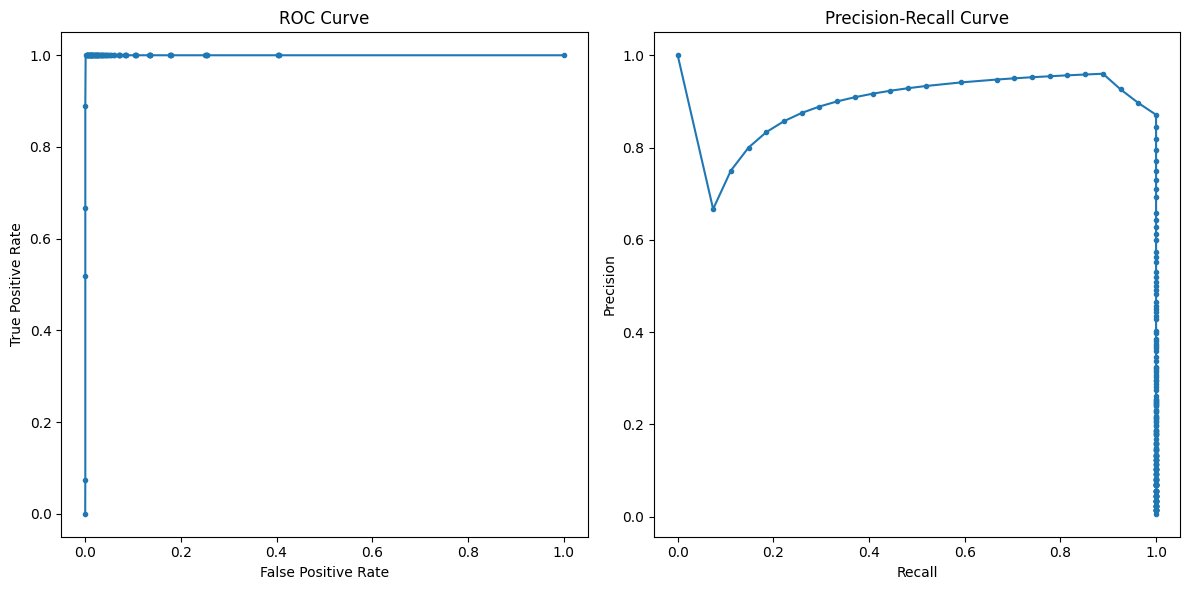

                         Feature    Importance
84                      SMR_VSA3  7.670801e-02
160                       fr_NH0  4.940489e-02
16   undefined_atom_stereo_count  3.485201e-02
130     NumAliphaticHeterocycles  3.276967e-02
133      NumAromaticHeterocycles  2.874067e-02
150                      fr_Ar_N  2.729639e-02
24                           qed  2.376878e-02
161                       fr_NH1  2.364031e-02
186                     fr_ether  2.360799e-02
82                     SMR_VSA10  2.072313e-02
14          rotatable_bond_count  2.041775e-02
138            NumRotatableBonds  1.635226e-02
107                  EState_VSA2  1.533469e-02
110                  EState_VSA5  1.525143e-02
96                    SlogP_VSA3  1.316612e-02
140     NumSaturatedHeterocycles  1.244071e-02
112                  EState_VSA7  1.225080e-02
35              FpDensityMorgan1  1.182081e-02
38                   BCUT2D_MWHI  1.152468e-02
128                      NOCount  1.138358e-02
47           

In [432]:
# Step 2
model_round_1, model_round_1_feature_importance = trainModelFinal(
    X, Y, 
    feature_list = positive_features[0].keys(),
    n_estimators = 400, 
    random_state=220, 
    sampling_strategy = 0.20)

# Iteration II

In [433]:
model_round_1_feature_importance_selected = model_round_1_feature_importance[model_round_1_feature_importance["Importance"]>1E-3]
print(len(model_round_1_feature_importance_selected["Feature"].tolist()))

148


In [439]:
# Step 1
avg_auc_score, auc_scores = trainModel4(
    X, Y, 
    feature_list = model_round_1_feature_importance_selected["Feature"].tolist(), # use only the selected features from previous iteraiton
    n_estimators = 400, 
    random_state=333, 
    n_splits=5, 
    sampling_strategy = 0.25)

AUC Scores for each fold: [0.8055235903337169, 0.8635212888377446, 0.860759493670886, 0.8521505376344086, 0.532258064516129]
Mean AUC Score: 0.782842594998577


number of training/test data before adasyn:  4370 4370
number of training/test data after adasyn:  5429
AUC: 1.00
Precision: 0.87
Recall: 1.00
F1 Score: 0.93
Confusion Matrix:
[[4339    4]
 [   0   27]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4343
           1       0.87      1.00      0.93        27

    accuracy                           1.00      4370
   macro avg       0.94      1.00      0.97      4370
weighted avg       1.00      1.00      1.00      4370

Log Loss: 0.01
Matthews Correlation Coefficient: 0.93


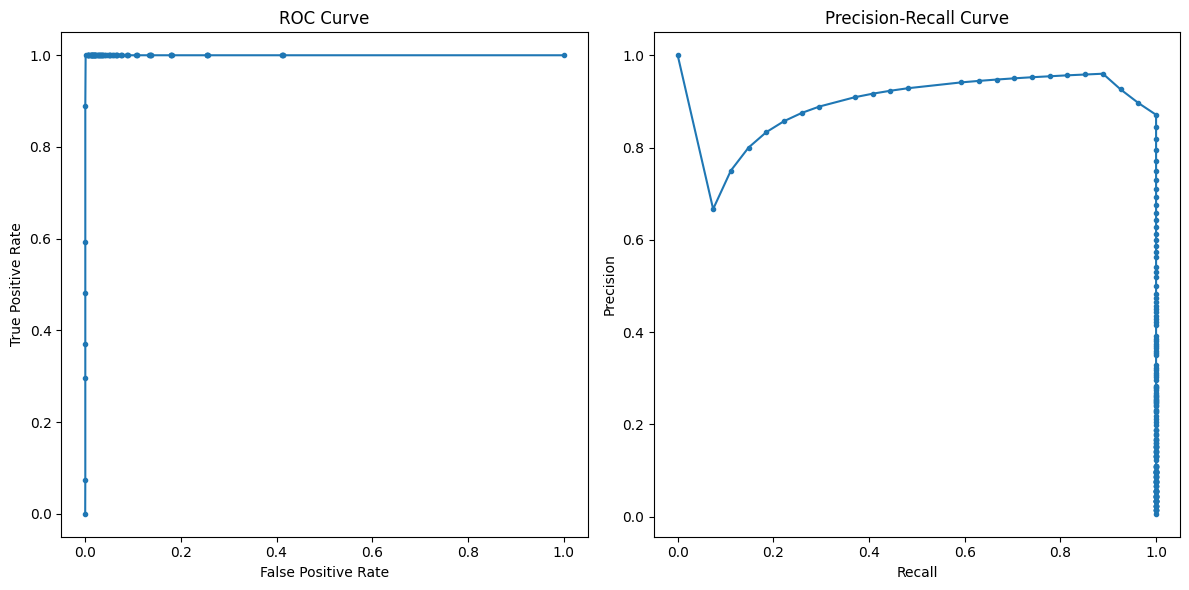

                         Feature  Importance
0                       SMR_VSA3    0.098136
1                         fr_NH0    0.049666
2    undefined_atom_stereo_count    0.036343
4        NumAromaticHeterocycles    0.030271
3       NumAliphaticHeterocycles    0.029043
11             NumRotatableBonds    0.026060
8                       fr_ether    0.024903
5                        fr_Ar_N    0.023736
9                      SMR_VSA10    0.022667
10          rotatable_bond_count    0.021551
6                            qed    0.020839
7                         fr_NH1    0.020056
14                    SlogP_VSA3    0.019189
13                   EState_VSA5    0.016531
16                   EState_VSA7    0.015639
18                   BCUT2D_MWHI    0.013700
17              FpDensityMorgan1    0.012989
20                      BalabanJ    0.012698
23                NumHeteroatoms    0.012598
22                         xlogp    0.011953
12                   EState_VSA2    0.011444
15      Nu

In [440]:
# Step 2
model_round_2, model_round_2_feature_importance = trainModelFinal(
    X, Y, 
    feature_list = model_round_1_feature_importance_selected["Feature"].tolist(),
    n_estimators = 400, 
    random_state=333, 
    sampling_strategy = 0.25)

## Iteration III

In [445]:
model_round_2_feature_importance_selected = model_round_2_feature_importance[model_round_2_feature_importance["Importance"]>1E-3]
print(len(model_round_2_feature_importance_selected["Feature"].tolist()))

141


## More Iterations ...

Skip the code for other iterations. They are essentially the same as the previous iterations

## Final iteration

In [466]:
# The final selected list of feature from the previous iteration was stored in an object feature_importance_df_selected. 
# The list contains 109 features
final_feature_list = feature_importance_df_selected["Feature"].tolist()
final_feature_list

['SMR_VSA3',
 'SlogP_VSA3',
 'BalabanJ',
 'qed',
 'NumAromaticHeterocycles',
 'FpDensityMorgan2',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'SlogP_VSA2',
 'FpDensityMorgan3',
 'fr_NH0',
 'Kappa1',
 'SMR_VSA1',
 'VSA_EState1',
 'monoisotopic_mass',
 'VSA_EState6',
 'SlogP_VSA5',
 'SlogP_VSA1',
 'SMR_VSA10',
 'PEOE_VSA9',
 'MolWt',
 'MolLogP',
 'Kappa2',
 'molecular_weight',
 'EState_VSA7',
 'EState_VSA5',
 'fr_ether',
 'MinAbsEStateIndex',
 'exact_mass',
 'ExactMolWt',
 'NumRotatableBonds',
 'rotatable_bond_count',
 'EState_VSA9',
 'NumValenceElectrons',
 'xlogp',
 'FractionCSP3',
 'SMR_VSA6',
 'MaxAbsPartialCharge',
 'MaxPartialCharge',
 'PEOE_VSA8',
 'VSA_EState5',
 'Chi1v',
 'NumAliphaticHeterocycles',
 'NOCount',
 'PEOE_VSA7',
 'tpsa',
 'undefined_atom_stereo_count',
 'NumHAcceptors',
 'BCUT2D_MRHI',
 'HeavyAtomMolWt',
 'MinEStateIndex',
 'BCUT2D_LOGPLOW',
 'EState_VSA4',
 'LabuteASA',
 'Chi2v',
 'VSA_EState4',
 'AvgIpc',
 'BCUT2D_MWLOW',
 'SlogP_VSA6',
 'VSA_EState2',
 'BCUT2D_

Step 1:

In [461]:
trainModel4(X, Y, final_feature_list, n_estimators = 400, random_state=220, n_splits=5, sampling_strategy = 0.20)

AUC Scores for each fold: [0.7840046029919449, 0.8917146144994248, 0.8487917146144994, 0.7808179723502304, 0.668394777265745]
Mean AUC Score: 0.7947447363443689


In [460]:
trainModel4(X, Y, final_feature_list, n_estimators = 500, random_state=220, n_splits=5, sampling_strategy = 0.15)

AUC Scores for each fold: [0.8113924050632911, 0.8390103567318756, 0.8737629459148446, 0.7796658986175116, 0.7081413210445469]
Mean AUC Score: 0.802394585474414


Step 2:

number of training/test data before adasyn:  4370 4370
number of training/test data after adasyn:  4990
AUC: 1.00
Precision: 0.87
Recall: 1.00
F1 Score: 0.93
Confusion Matrix:
[[4339    4]
 [   0   27]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4343
           1       0.87      1.00      0.93        27

    accuracy                           1.00      4370
   macro avg       0.94      1.00      0.97      4370
weighted avg       1.00      1.00      1.00      4370

Log Loss: 0.01
Matthews Correlation Coefficient: 0.93


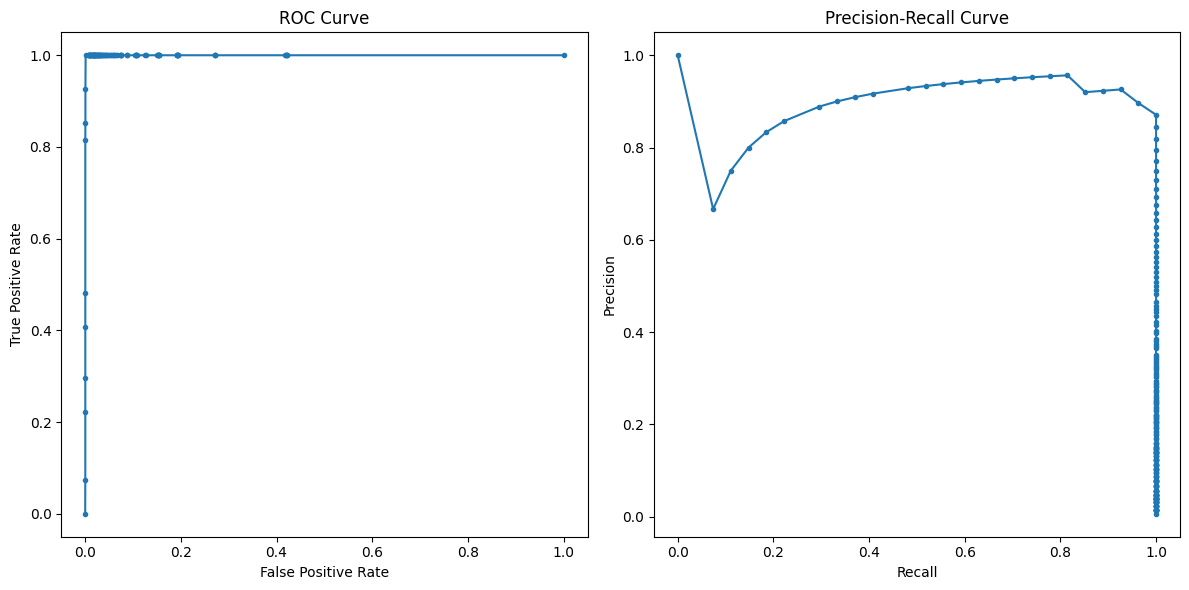

                         Feature  Importance
0                       SMR_VSA3    0.101656
10                        fr_NH0    0.060590
4        NumAromaticHeterocycles    0.040516
46   undefined_atom_stereo_count    0.040257
26                      fr_ether    0.033790
42      NumAliphaticHeterocycles    0.033761
3                            qed    0.028514
61                       fr_Ar_N    0.025746
30             NumRotatableBonds    0.024715
18                     SMR_VSA10    0.023986
31          rotatable_bond_count    0.021932
60                   BCUT2D_MWHI    0.020349
25                   EState_VSA5    0.016603
24                   EState_VSA7    0.014097
102               NumHeteroatoms    0.013853
2                       BalabanJ    0.013388
7               FpDensityMorgan1    0.012593
97                   EState_VSA2    0.012502
34                         xlogp    0.012175
39                     PEOE_VSA8    0.012063
36                      SMR_VSA6    0.011962
43        

In [467]:
modelFinal, featureImportanceFinal =  trainModelFinal(
    X, Y, 
    final_feature_list, 
    n_estimators = 500, 
    random_state=220, 
    sampling_strategy = 0.15
)

## Save the final model

In [369]:
save_object_to_disk(modelFinal, "model_balance_weight.pkl")
save_object_to_disk(featureImportanceFinal, "model_balance_weight_featureImportanceFinal.pkl")


Object data has been serialized and saved to file.
Object data has been serialized and saved to file.


# Understanding the Final Model

## List of final features and their importances

In [472]:
# view the list of features and their importances
featureImportanceFinal

,Feature,Importance
0,SMR_VSA3,0.101656
10,fr_NH0,0.060590
4,NumAromaticHeterocycles,0.040516
46,undefined_atom_stereo_count,0.040257
26,fr_ether,0.033790
...,...,...
105,Chi3v,0.002062
108,NHOHCount,0.001804
101,VSA_EState10,0.001475
85,fr_allylic_oxid,0.001089


In [474]:
# only look at the top features
featureImportanceFinal.head(15)

,Feature,Importance
0,SMR_VSA3,0.101656
10,fr_NH0,0.060590
4,NumAromaticHeterocycles,0.040516
46,undefined_atom_stereo_count,0.040257
26,fr_ether,0.033790
42,NumAliphaticHeterocycles,0.033761
3,qed,0.028514
61,fr_Ar_N,0.025746
30,NumRotatableBonds,0.024715
18,SMR_VSA10,0.023986


In [475]:
# create a latex table to list feature importances in a table
for index, row in featureImportanceFinal.head(15).iterrows():
    print(f"{row['Feature']} & {row['Importance']:.4f} \\\\".replace('_', '\\_'))
    print("\\hline")

SMR\_VSA3 & 0.1017 \\
\hline
fr\_NH0 & 0.0606 \\
\hline
NumAromaticHeterocycles & 0.0405 \\
\hline
undefined\_atom\_stereo\_count & 0.0403 \\
\hline
fr\_ether & 0.0338 \\
\hline
NumAliphaticHeterocycles & 0.0338 \\
\hline
qed & 0.0285 \\
\hline
fr\_Ar\_N & 0.0257 \\
\hline
NumRotatableBonds & 0.0247 \\
\hline
SMR\_VSA10 & 0.0240 \\
\hline
rotatable\_bond\_count & 0.0219 \\
\hline
BCUT2D\_MWHI & 0.0203 \\
\hline
EState\_VSA5 & 0.0166 \\
\hline
EState\_VSA7 & 0.0141 \\
\hline
NumHeteroatoms & 0.0139 \\
\hline


## Generate histogram of feature Importsance


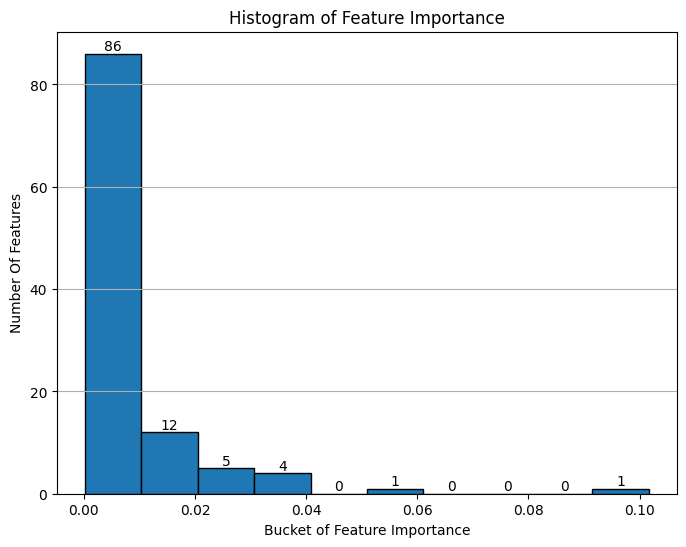

In [370]:
import pandas as pd
import matplotlib.pyplot as plt

df = featureImportanceFinal

# Plotting the histogram
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
counts, bins, patches = plt.hist(df['Importance'], bins=10, edgecolor='black')  # `bins` controls the number of bins
plt.title('Histogram of Feature Importance')
plt.xlabel('Bucket of Feature Importance')
plt.ylabel('Number Of Features')
plt.grid(axis='y') # show only the horizontal grid line

# Add y-values on top of the bars
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, str(int(count)), 
             ha='center', va='bottom')

plt.savefig('acne_feature_importance_histogram.png')  # Save the plot as a PNG file
plt.show()

# Have a quick sense of the model prediction on the compounds in the training dataset

## Positive samples

Generating prediction scores using the model and features

In [527]:
X_positive_pred = pd.DataFrame(positive_features)[final_feature_list]
clean_data(X_positive_pred)
Y_positive_pred = modelFinal.predict_proba(X_positive_pred)
#Y_positive_pred = [i[1] for i in Y_positive_pred]
Y_positive_pred

array([[0.262     , 0.738     ],
       [0.286     , 0.714     ],
       [0.02097244, 0.97902756],
       [0.1       , 0.9       ],
       [0.02097244, 0.97902756],
       [0.234     , 0.766     ],
       [0.34814967, 0.65185033],
       [0.284     , 0.716     ],
       [0.09810239, 0.90189761],
       [0.224     , 0.776     ],
       [0.24      , 0.76      ],
       [0.136     , 0.864     ],
       [0.35      , 0.65      ],
       [0.39592704, 0.60407296],
       [0.18203656, 0.81796344],
       [0.344     , 0.656     ],
       [0.258     , 0.742     ],
       [0.352     , 0.648     ],
       [0.42132047, 0.57867953],
       [0.224     , 0.776     ],
       [0.26      , 0.74      ],
       [0.268     , 0.732     ],
       [0.25      , 0.75      ],
       [0.24497775, 0.75502225],
       [0.238     , 0.762     ],
       [0.228     , 0.772     ],
       [0.24      , 0.76      ]])

Draw the positive compounds with their names and image

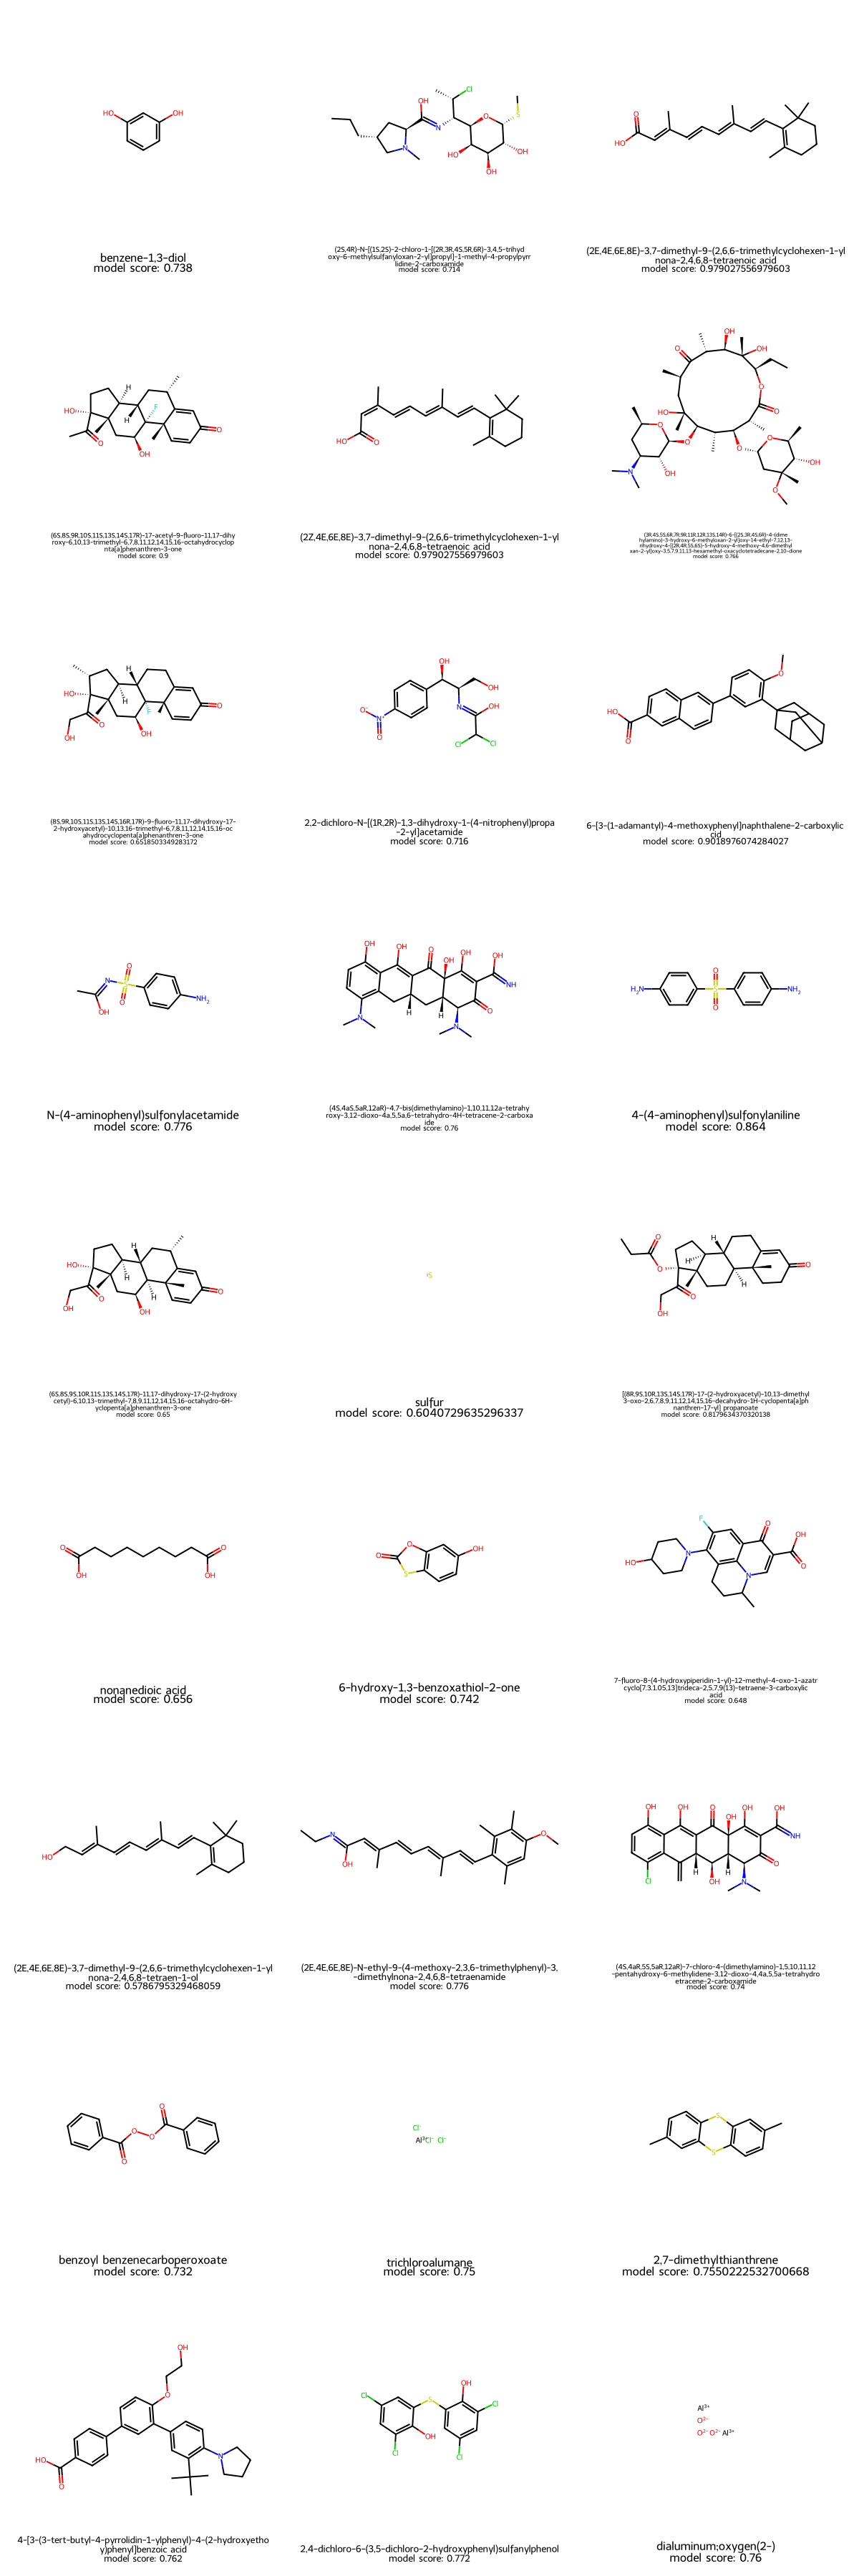

In [528]:
from rdkit import Chem
from rdkit.Chem import Draw

# Lengend is a combination of iupc name and atc code. Break them into multiple lines for drawing 
# I could not find atc code for all of them. 
def genLegend(c):
    # c is a tuple <compound, level4AtcCode>
    return c[0].iupac_name[0:60] + "\n" + c[0].iupac_name[61:120] + "\n" + c[0].iupac_name[121:180] + "\n" + c[0].iupac_name[181:] + "\n" \
        + "\n" + "model score: " + str(c[1][1])
    

names = [genLegend(c) for c in zip(positive_compounds, Y_positive_pred)]
#names = [c.synonyms for c in positive_compounds]
molecules = [getRdkitMoleculeFromPubChemCompound(c) for c in positive_compounds]
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(400, 400), legends=names)
img

## Negative Samples

In [505]:
def clean_data(df_X):
        # feature cleaning: some numbers are in string format, convert them to numbers
    string_columns = df_X.select_dtypes(include='object').columns.tolist()
    for i in string_columns:
        df_X[i] = pd.to_numeric(df_X[i])

    # feature cleaning: replace NAN and INF with special values. They are rare in the data but cause errors if not replaced.
    df_X.replace([np.nan], -1, inplace=True)
    df_X.replace([np.inf], np.finfo(np.float32).max, inplace=True)
    df_X.replace([-np.inf], np.finfo(np.float32).min, inplace=True)

    # feature cleaning: some numbers in RDKit is too large for float32
    df_X.loc[df_X['Ipc'] > 3.4028235e38, 'Ipc'] = np.finfo(np.float32).max  


In [531]:
X_negative_pred = pd.DataFrame(negative_features)[final_feature_list]
clean_data(X_negative_pred)
Y_negative_pred = modelFinal.predict_proba(X_negative_pred)
#Y_positive_pred = [i[1] for i in Y_positive_pred]
Y_negative_pred

array([[0.984     , 0.016     ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [0.998     , 0.002     ],
       [0.98445911, 0.01554089]])

In [532]:
# show some random rows 
Y_negative_pred[np.random.choice(Y_negative_pred.shape[0], 20, replace=False)]

array([[0.994    , 0.006    ],
       [1.       , 0.       ],
       [1.       , 0.       ],
       [1.       , 0.       ],
       [0.9826398, 0.0173602],
       [1.       , 0.       ],
       [1.       , 0.       ],
       [0.994    , 0.006    ],
       [1.       , 0.       ],
       [0.9815755, 0.0184245],
       [0.996    , 0.004    ],
       [1.       , 0.       ],
       [0.998    , 0.002    ],
       [1.       , 0.       ],
       [0.986    , 0.014    ],
       [0.994    , 0.006    ],
       [0.984    , 0.016    ],
       [1.       , 0.       ],
       [1.       , 0.       ],
       [1.       , 0.       ]])